In [1]:
import os
import cv2
import mediapipe as mp

import numpy as np
from deepface import DeepFace
from deepface.commons import functions

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# extract faces from the picture, aligns them and makes them 244 x 244
# saves them in the faces folder
def face_alignment(image_directory, case="all"):
    all_images = os.listdir(image_directory)

    model_name = "VGG-Face"
    target_size = functions.find_target_size(model_name = model_name)

    for index, relative_image_path in enumerate(all_images):
        image_path = os.path.join(image_directory, relative_image_path)
        
        # detects faces in image using Multi-Task Cascaded Convolutional Neural Networks, extracts faces and aligns them
        # mtcnn is robust: it detects faces even with different sizes, lighting and strong rotations
        # mtcnn vs harr_cascade (openCV's face detector): https://datawow.io/blogs/face-detection-haar-cascade-vs-mtcnn

        # returns a array of faces, each face is a dictionary containing:
        # an array that represents the image, a confidence score on the face and
        all_faces = DeepFace.extract_faces(img_path = image_path, grayscale = True,
                                            enforce_detection = False, detector_backend ="mtcnn")

        if(len(all_faces) == 1):
            face = (all_faces[0])['face']

            # print(img1[0])
            # print(face)
            # print(type(face))

            # im = cv2.cvtColor(img1 * 255, cv2.COLOR_BGR2RGB)

            # cv2.imshow('image', face)
            # cv2.waitKey(0)

            face_path = f"./{case}/face{index}.jpg"
            cv2.imwrite(face_path, face * 255) 

        else:
            # img1 = np.expand_dims(img1, axis=0) #(224, 224, 3) to (1, 224, 224, 3)

            print("Multiple faces detected. Discarding image.")

In [3]:
face_alignment("../archive/main/no_stroke", "no_droop")
face_alignment("../archive/main/stroke_data", "droop")

1/1 [==============================] - 0s 30ms/step
Multiple faces detected. Discarding image.
1/1 [==============================] - 0s 27ms/step
Multiple faces detected. Discarding image.
1/1 [==============================] - 0s 30ms/step
Multiple faces detected. Discarding image.
1/1 [==============================] - 0s 23ms/step
Multiple faces detected. Discarding image.
1/1 [==============================] - 0s 19ms/step
Multiple faces detected. Discarding image.
1/1 [==============================] - 0s 23ms/step
Multiple faces detected. Discarding image.
1/1 [==============================] - 0s 19ms/step


ValueError: Confirm that ../archive/main/stroke_data\faces exists

In [ ]:
face_alignment("./test_images/", "test_faces")

In [ ]:
def create_file_csv(directory, image_class):
    header = ['image_path', 'class']

    def get_face_int(filename):
        return int(filename.split('.')[0].split('face')[1])

    all_files = sorted(os.listdir(directory), key=get_face_int)
    
    if (image_class == "no_droop"):
        all_paths = pd.DataFrame([(os.path.join(directory, file), image_class) for file in all_files], columns = header)
        all_paths.to_csv("image_paths.csv", index = False, mode = "w")
    else:
        all_paths = pd.DataFrame([(os.path.join(directory, file), image_class) for file in all_files])
        all_paths.to_csv("image_paths.csv", index = False, mode = "a", header = False)

    

In [ ]:
create_file_csv("./no_droop/", "no_droop")
create_file_csv("./droop/", "droop")

In [6]:
from shapely.geometry import Polygon
from numpy import ones,vstack
from numpy.linalg import lstsq

# function to return the coordinates of lanmark points 
def landmarks_to_coords(landmarks, facial_area, zipped=True):
    x_ords = []
    y_ords = []

    for point in facial_area:
        landmark = landmarks.landmark[point]
        x_ords.append(landmark.x)
        y_ords.append(landmark.y)

    if(zipped):
        return zip(x_ords, y_ords)
    else:
        return np.vstack((x_ords, y_ords)).T
    
# function to return the line of best fit uaing the least squaares method when given landmark points
def get_line(coordinates):
    x_ords, y_ords = np.split(coordinates,2,axis=1)

    x_ords=x_ords.flatten()
    y_ords=y_ords.flatten()

    A = vstack([x_ords,ones(len(x_ords))]).T
    m, c = lstsq(A, y_ords)[0]

    #print(str(m) + ", " + str(c))

    return m, c

# function to reflect coordinates over a given line
def reflect_points(coordinates, m, c):
    reflection_mat = np.array([[((1-m**2)/(1+m**2)), ((2*m)/(1+m**2))],
              [((2*m)/(1+m**2)), ((m**2-1)/(1+m**2))]])
    reflected_coordinates = []
    temp = []
    for coord in coordinates:
        #x = (((1 - m**2)*coord[0]) + 2*m*coord[1] - 2*m*c)/1+m**2
        #y = ((2*m*coord[0]) + (m**2 - 1)*coord[1] + (2*c))/1+m**2

        #np.matmul(, reflection_mat)

        x = (-(m**2*coord[0]) - 2*m*c)/m**2
        y = ((m**2)*coord[1])/m**2
        reflected_coordinates.append([x,y])

    return reflected_coordinates

# function to calculate the symmetry between a feature on the left and right side of the face
# reflects the feature on the right side to the left side over the mid-line of the face and 
# gets the difference between the reflected right coordinates and the corresponsing left coordinates
def get_feature_symmetry(landmarks, mid_face, right_landmarks, left_landmarks):
    diff = 0
    mid_face_coordinates = landmarks_to_coords(landmarks, mid_face, False)
    right_coordinates = landmarks_to_coords(landmarks, right_landmarks, False)
    left_coordinates = landmarks_to_coords(landmarks, left_landmarks, False)
    m, c = get_line(mid_face_coordinates)
    reflected_right = reflect_points(right_coordinates, m, c)

    for index,  reflected_right_coord in enumerate(reflected_right):
        left_coord = left_coordinates[index]
        diff += abs(left_coord[0] - reflected_right_coord[0])
        diff += abs(left_coord[1] - reflected_right_coord[1])

    return diff

# calculates the area of a given feature
# feature should be closed
def calculate_feature_area(landmarks, facial_area):
    coordinates = landmarks_to_coords(landmarks, facial_area)
    feature = Polygon(coordinates)
    plt.plot(*feature.exterior.xy)

    return feature.area

# calculates the gradients given a start point and en end point
def calculate_gradient(landmarks, facial_area):
    zipped_coords = landmarks_to_coords(landmarks, facial_area)
    coordinates = list(zipped_coords)

    return ((coordinates[0][1] - coordinates[1][1]) / (coordinates[0][0] - coordinates[1][0]))

# function to calculate ratio of area of feature 
def calculate_area_ratio(right_area, left_area):
    areas = [right_area, left_area]

    area1 = areas[areas.index(max(areas))]
    area2 = areas[areas.index(min(areas))]

    return (area1 / area2)


In [9]:
mp_face_mesh = mp.solutions.face_mesh

face_mesh = mp_face_mesh.FaceMesh(static_image_mode = True)

premade_facial_features = {
    "lips": mp_face_mesh.FACEMESH_LIPS,
    "left_eye": mp_face_mesh.FACEMESH_LEFT_EYE,
    "left_eyebrow": mp_face_mesh.FACEMESH_LEFT_EYEBROW,
    "right_eye": mp_face_mesh.FACEMESH_RIGHT_EYE,
    "right_eyebrow": mp_face_mesh.FACEMESH_RIGHT_EYEBROW
}

facial_features = {
    'right_eye_inner': [362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382, 362], # inner corner -> outer corner -> inner_corner
    'left_eye_inner': [133, 173, 157, 158, 159, 160, 161, 246, 33, 7, 163, 144, 145, 153, 154, 155, 133],
    'right_eye_corners': [263, 362],  # outer -> inner
    'left_eye_corners': [33, 133 ],
    'right_cheek_line':[358, 423, 426, 436, 432],
    'left_cheek_line':[129, 203, 206, 216, 212],
    'mouth_corners': [61, 291],  # left to right
    'inner_mouth': [62, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 
                    292, 324, 318, 402, 317, 14, 87, 178, 88, 95, 78],
    'right_mouth_outer': [0, 17, 314, 405, 321, 375, 291, 409, 270, 269, 267, 0],
    'left_mouth_outer' : [0, 17, 84, 181, 91, 146, 61, 185, 40, 39, 37 , 0], 
    'mid_line': [10, 151, 9, 200, 199, 175, 152]
                                     
}

def feature_extraction(directory, face_class):
    header = ['cheek_line_similarity', 'eye_similarity', 'eye_area_ratio', 'right_eye_gradient', 'left_eye_gradient', 'mouth_similarity', 'mouth_area_ratio', 'mouth_gradient', 'inner_mouth_area', 'class']
    calculated_features = []
    
    count = 0

    for index, file in enumerate(os.listdir(directory)):
        file_path = os.path.join(directory, file)
        image = cv2.imread(file_path)
        # cv2.imshow('image',image)
        # cv2.waitKey(0)
        
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        try:
            landmarks = results.multi_face_landmarks[0]
        except TypeError:
            print("typeError")
            continue

        right_eye_gradient = calculate_gradient(landmarks, facial_features['right_eye_corners'])
        left_eye_gradient = calculate_gradient(landmarks, facial_features['left_eye_corners'])
        right_eye_area = calculate_feature_area(landmarks, facial_features['right_eye_inner'])
        left_eye_area = calculate_feature_area(landmarks, facial_features['left_eye_inner'])
        
        mouth_gradient = calculate_gradient(landmarks, facial_features['mouth_corners'])
        inner_mouth_area = calculate_feature_area(landmarks, facial_features['inner_mouth'])
        right_mouth_area = calculate_feature_area(landmarks, facial_features['right_mouth_outer'])
        left_mouth_area = calculate_feature_area(landmarks, facial_features['left_mouth_outer'])

        cheek_line_sim = get_feature_symmetry(landmarks, facial_features['mid_line'], 
                                              facial_features['right_cheek_line'], facial_features['left_cheek_line'])
        
        eye_sim = get_feature_symmetry(landmarks, facial_features['mid_line'], 
                                              facial_features['right_eye_inner'], facial_features['left_eye_inner'])
        
        mouth_sim = get_feature_symmetry(landmarks, facial_features['mid_line'], 
                                              facial_features['right_mouth_outer'], facial_features['left_mouth_outer'])

        eye_area_ratio = calculate_area_ratio(right_eye_area, left_eye_area)
        mouth_area_ratio = calculate_area_ratio(right_mouth_area, left_mouth_area)

        calculated_features.append([cheek_line_sim, eye_sim, eye_area_ratio, right_eye_gradient, left_eye_gradient, mouth_sim, mouth_area_ratio, mouth_gradient, inner_mouth_area, face_class])

        count += 1
        
        if count >= 300:
            print("done!")
            break

    if (face_class == "no_droop"):
        extracted_features = pd.DataFrame(calculated_features, columns = header)
        extracted_features.to_csv("data.csv", index = False, mode = "w")
    else:
        extracted_features = pd.DataFrame(calculated_features)
        extracted_features.to_csv("data.csv", index = False, mode = "a", header = False)



In [ ]:
feature_extraction("./test_images/", "test")

typeError
done!


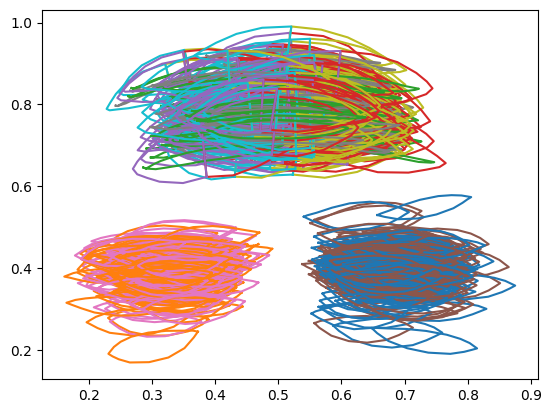

In [10]:
feature_extraction("./no_droop/", "no_droop")
feature_extraction("./droop/", "droop")

In [ ]:
def dict_list_to_frozenset(dictionary):
    keys = list(dictionary.keys())

    print(dictionary[keys[0]])

    for feature in dictionary:
        arr = []

        current_feature = dictionary[feature]
        for index, point in enumerate(current_feature):
            if (index < len(current_feature) - 1):
                arr.append(tuple((current_feature[index], current_feature[index + 1])))

        print(feature)
        print(arr)
        fs = frozenset(arr)

    
fs_facial_features = {
    'right_eye_inner': frozenset([(362, 398), (398, 384), (384, 385), (385, 386), (386, 387), (387, 388), (388, 466), (466, 263), (263, 249), (249, 390), (390, 373), (373, 374), (374, 380), (380, 381), (381, 382), (382, 362)]),
    'left_eye_inner': frozenset([(133, 173), (173, 157), (157, 158), (158, 159), (159, 160), (160, 161), (161, 246), (246, 33), (33, 7), (7, 163), (163, 144), (144, 145), (145, 153), (153, 154), (154, 155), (155, 133)]),
    'right_eye_corners': frozenset([(263, 362)]),
    'left_eye_corners': frozenset([(33, 133)]),
    'right_cheek_line': frozenset([(358, 423), (423, 426), (426, 436), (436, 432)]),
    'left_cheek_line': frozenset([(129, 203), (203, 206), (206, 216), (216, 212)]),
    'mouth_corners': frozenset([(61, 291)]),
    'inner_mouth': frozenset([(62, 78), (78, 191), (191, 80), (80, 81), (81, 82), (82, 13), (13, 312), (312, 311), (311, 310), (310, 415), (415, 308), (308, 292), (292, 324), (324, 318), (318, 402), (402, 317), (317, 14), (14, 87), (87, 178), (178, 88), (88, 95), (95, 78)]),
    'right_mouth_outer': frozenset([(0, 17), (17, 314), (314, 405), (405, 321), (321, 375), (375, 291), (291, 409), (409, 270), (270, 269), (269, 267), (267, 0)]),
    'left_mouth_outer' : frozenset([(0, 17), (17, 84), (84, 181), (181, 91), (91, 146), (146, 61), (61, 185), (185, 40), (40, 39), (39, 37), (37, 0)]),
    'mid_line': frozenset([(10, 151), (151, 9), (9, 200), (200, 199), (199, 175), (175, 152)]),
                                     
}

def test_chosen_features (directory):    

    for idx, relative_file in enumerate(os.listdir(directory)):
        file = os.path.join(directory, relative_file)
        image = cv2.imread(file)
        
        img1 = DeepFace.extract_faces(img_path = image, detector_backend ="mtcnn")
        # print(img1)



        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        landmarks = results.multi_face_landmarks[0]

        print((landmarks.landmark[2]).x)
        print((landmarks.landmark[2]).y)

        # for each one of the 468 points, get the coordinates, normalixe them to the image and plot a point there
        for landmark in landmarks.landmark:
            x = landmark.x
            y = landmark.y
            
            relative_x = int(image.shape[1] * x)
            relative_y = int(image.shape[0] * y)
            
            #cv2.circle(image, (relative_x, relative_y), 1, (0, 0, 255), -1)

        def plot_landmark(img_base, facial_area_obj):    
            for source_idx, target_idx in facial_area_obj:
                source = landmarks.landmark[source_idx]
                target = landmarks.landmark[target_idx]
            
                relative_source = (int(image.shape[1] * source.x), int(image.shape[0] * source.y))
                relative_target = (int(image.shape[1] * target.x), int(image.shape[0] * target.y))
            
                cv2.line(image, relative_source, relative_target, (255, 0, 0), thickness = 1)
                
        for feature in fs_facial_features:
            plot_landmark(image, fs_facial_features[feature])
            
        cv2.imshow('image',image)
        cv2.waitKey(0)


In [ ]:
#dict_list_to_frozenset(facial_features)
test_chosen_features('./test_images/')